<a href="https://colab.research.google.com/github/samuel-c-santos/s2dr4-sentinel-auto-inference/blob/main/S2DR4_Inferencia_V4_2026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gamma Earth S2DR4 - Sentinel-2 Deep Resolution 4.0
## Super-resolução de Imagem Única de 10 Bandas e 10x para Sentinel-2 Eficaz

Este notebook demonstra o desempenho do módulo S2DR4. A descrição detalhada do módulo, bem como a análise de desempenho, podem ser encontradas no seguinte white paper. Entre em contato com info@gamma.earth para funcionalidades estendidas, uso comercial e outras consultas.

O módulo S2DR4 buscará dados do Sentinel-2 para o local e data fornecidos e aplicará super-resolução nas 10 bandas multiespectrais, passando da resolução original de 10m e 20m para a resolução espacial alvo de 1m/px. O resultado é uma imagem TIF georreferenciada multiespectral de 10 bandas e 1m/px. O produto de saída será gerado no caminho do sistema de arquivos local '/content/output' localizado aqui:


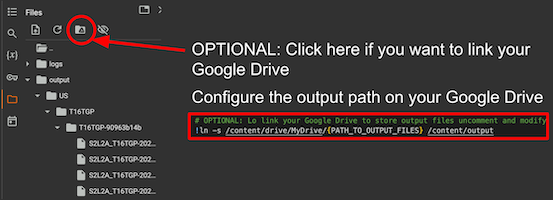

A saída conterá 4 produtos:

S2L2Ax10_T[MGRS]-[UID]-[DATE]_MS.tif – Imagem multiespectral de 10 bandas

S2L2Ax10_T[MGRS]-[UID]-[DATE]_TCI.tif – Imagem RGB de cor verdadeira

S2L2Ax10_T[MGRS]-[UID]-[DATE]_NDVI.tif – Imagem NDVI em falsa cor

S2L2Ax10_T[MGRS]-[UID]-[DATE]_IRP.tif – Imagem infravermelha em falsa cor

A ordem das 10 bandas no produto multiespectral é: B02, B03, B04, B05, B06, B07, B08, B8A, B11, B12.

# Instalação

In [ ]:
# 1. Instalação do módulo S2DR4 (Core)
!pip -q install https://storage.googleapis.com/0x7ff601307fa5/s2dr4-20260205.1-cp312-cp312-linux_x86_64.whl

# 2. Instalação de dependências para manipulação de dados geoespaciais e GEE
# O rasterio é essencial para você ler as 10 bandas de 1m que o S2DR4 gera
!pip -q install earthengine-api rasterio geemap

# 3. Importação das bibliotecas no ambiente
import ee
import os
import rasterio
from google.colab import drive

print("Ambiente configurado com sucesso para S2DR4!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 5.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.3/254.3 kB 18.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 9.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Seleção automática da melhor imagem

In [ ]:
import ee

# 1. Autenticação e Inicialização (Mantenha seu projeto)
try:
    ee.Initialize(project='seu-projeto-aqui')
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project='seu-projeto-aqui')

# 2. Coordenadas do ponto (WGS84) (IDEFLOR-Bio - Belém/PA)
lon, lat = -48.4443399, -1.4248187
point = ee.Geometry.Point([lon, lat])

# 3. Seleção da Imagem (Janeiro de 2025 com 20% de nuvens)
collection = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") # Recomendado usar Harmonized para datas recentes
    .filterBounds(point)
    .filterDate('2025-12-01', '2026-02-06')  # Ajuste o intervalo de datas no formato AAAA-MM-DD
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)) # Limite de Nuvens Ex.: 30%
    .sort('CLOUDY_PIXEL_PERCENTAGE')
)

# 4. Verificação e extração da data
n_images = collection.size().getInfo()

if n_images == 0:
    print("Nenhuma imagem encontrada em Janeiro com < 20% de nuvens. Tentando buscar a melhor do ano...")
    # Opcional: Busca a melhor do ano caso não encontre imagens limpas no intervalo
    collection = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
                  .filterBounds(point)
                  .filterDate('2025-01-01', '2025-12-31')
                  .sort('CLOUDY_PIXEL_PERCENTAGE'))
    image = ee.Image(collection.first())
else:
    image = ee.Image(collection.first())
    print(f"Sucesso! Encontradas {n_images} imagens. Selecionando a mais limpa.")

date = image.date().format('YYYY-MM-dd').getInfo()
print("Melhor data para o processamento S2DR4:", date)

# 5. Preparação para o S2DR4
lonlat = (lon, lat)

Sucesso! Encontradas 1 imagens. Selecionando a mais limpa.
Melhor data para o processamento S2DR4: 2026-01-06


# Limpar saídas anteriores

In [ ]:
#limpar o output
import shutil
import os

# Apaga o conteúdo antigo da pasta de saída
output_dir = '/content/output'
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir)

print("Pasta de saída limpa!")

Pasta de saída limpa!


# Inferencia

Preprocessing T22MGD-c55b89599-20250812 (1)  done.
Preprocessing T22MGD-c55b89599-20260109 (94) xxxxxxxxxxxxxx Alignment failed.
Preprocessing T22MGD-c55b89599-20260106 (21) .x.x..xx.x.... done.
Preprocessing T22MGD-c55b89599-20251227 (61) xxxx..xxx....x done.
Preprocessing T22MGD-c55b89599-20251217 (53) .xx.xxx.x..x.x done.
Preprocessing T22MGD-c55b89599-20251210 (11) ..x........... done.
Preprocessing T22MGD-c55b89599-20251207 (91) xx..xxxxxx..xx done.


Fetching model: 100%|██████████| 841M/841M [00:09<00:00, 85.8MiB/s]


Processing T22MGD-c55b89599-20260106 . done.
Postprocessing T22MGD-c55b89599-20260106 .....,..,.. done.

Find results at the following path: /content/output
Click the link below for preview:

https://gamayos.github.io/gamma-earth-api/s2dr4-sd-demo-01.html?ds=BR-T22MGD-c55b89599-20260106#15/-1.4248/-48.4443



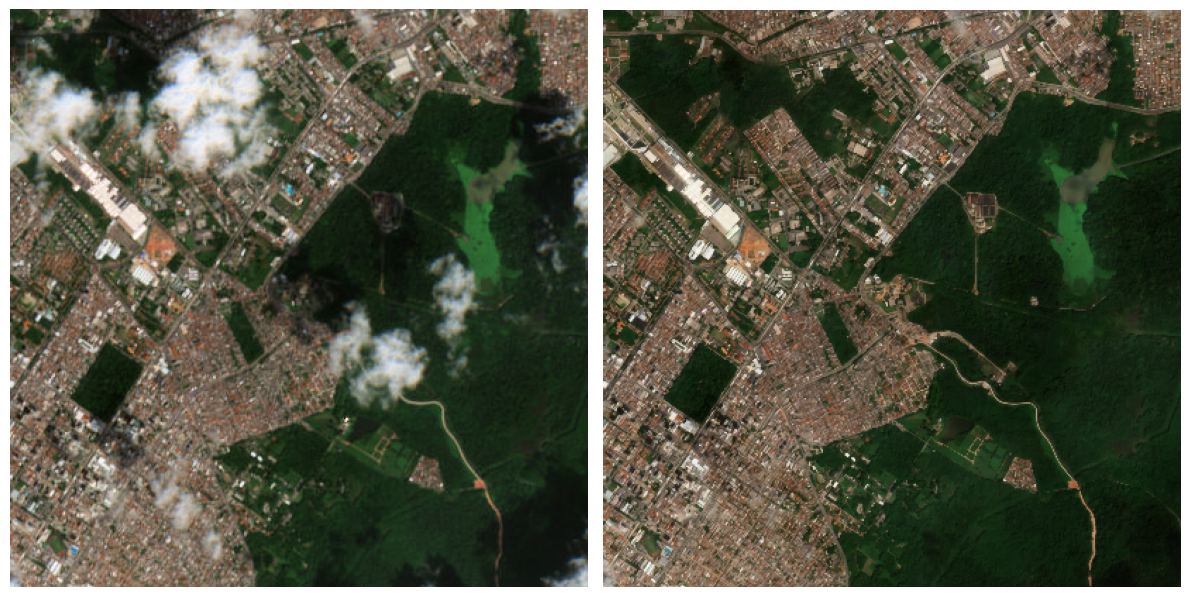

In [ ]:
import s2dr4.inferutils

# Define a tupla de coordenadas no formato (Longitude, Latitude)
# utilizando as variáveis globais configuradas anteriormente.
lonlat = (lon, lat)

# Executa o processamento de super-resolução (S2DR4)
# O modelo buscará a cena do Sentinel-2 mais próxima da data filtrada
# e gerará os produtos de 1m/px no diretório /content/output
s2dr4.inferutils.test(lonlat=lonlat, date=date)

# Licença / License

**Copyright (c) Gamma Earth Sarl 2026**

O software é fornecido para fins de teste, avaliação de desempenho e validação. Todos os direitos são reservados pelo proprietário dos direitos autorais. Para funcionalidades estendidas e uso comercial, entre em contato com: **info@gamma.earth**

*The software is provided for testing, performance evaluation and validation. All rights are reserved by the copyright owner. For extended functionality and commercial use please contact info@gamma.earth*

---

### Como Citar / How to Cite

Para publicações acadêmicas ou relatórios técnicos relacionados ao uso do S2DR4, utilize a seguinte citação:

> Yosef Akhtman, S2DR4: Effective 10-Band 10x Single Image Super-Resolution for Sentinel-2. Medium: [https://medium.com/@ya_71389/c71a601a2253](https://medium.com/@ya_71389/c71a601a2253)

---

### Termos de Uso / Disclaimer

Observe que imagens de satélite selecionadas, geradas por usuários anônimos, podem ser reutilizadas para fins de divulgação.

**O SOFTWARE É FORNECIDO "COMO ESTÁ" (AS IS), SEM GARANTIA DE QUALQUER TIPO, EXPRESSA OU IMPLÍCITA, INCLUINDO, MAS NÃO SE LIMITANDO ÀS GARANTIAS DE COMERCIALIZAÇÃO, ADEQUAÇÃO A UM DETERMINADO FIM E NÃO VIOLAÇÃO. EM NENHUMA HIPÓTESE OS AUTORES OU DETENTORES DOS DIREITOS AUTORAIS SERÃO RESPONSÁVEIS POR QUALQUER RECLAMAÇÃO, DANOS OU OUTRA RESPONSABILIDADE, SEJA EM AÇÃO DE CONTRATO, ILÍCITO OU DE OUTRA FORMA, DECORRENTE DE, FORA DE OU EM CONEXÃO COM O SOFTWARE OU O USO OU OUTRAS NEGOCIAÇÕES NO SOFTWARE.**

*THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.*